In [1]:
# !pip install pycocotools

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

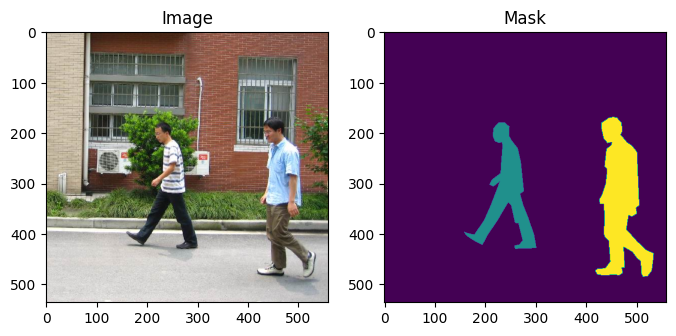

In [2]:
# One example from the loaded dataset - image and mask
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("data/PennFudanPed/PNGImages/FudanPed00001.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00001_mask.png")

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0)) # chw - hwc
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [3]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load and sort to make sure they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load each image and mask
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        # split the color-encoded mask into a set of binary masks
        # now each object has its own 0 1 mask
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # Load a Mask R-CNN model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    # Retrieve the number of input features for the box predictor
    box_in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the box predictor with a new one for the custom number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(box_in_features, num_classes)
    # Get the input features for the mask predictor
    mask_in_features = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_units = 256
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        mask_in_features, hidden_units, num_classes
    )
    return model

In [5]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [6]:
# run once
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [7]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set with random indices
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("Done!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 70.4MB/s]
/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:03:53  lr: 0.000090  loss: 4.4725 (4.4725)  loss_classifier: 0.6779 (0.6779)  loss_box_reg: 0.5082 (0.5082)  loss_mask: 3.2665 (3.2665)  loss_objectness: 0.0120 (0.0120)  loss_rpn_box_reg: 0.0080 (0.0080)  time: 3.8968  data: 0.0755  max mem: 2366
Epoch: [0]  [10/60]  eta: 0:00:41  lr: 0.000936  loss: 1.6990 (2.1556)  loss_classifier: 0.4594 (0.4517)  loss_box_reg: 0.2656 (0.3161)  loss_mask: 0.7452 (1.3637)  loss_objectness: 0.0120 (0.0186)  loss_rpn_box_reg: 0.0050 (0.0055)  time: 0.8263  data: 0.0342  max mem: 2764
Epoch: [0]  [20/60]  eta: 0:00:28  lr: 0.001783  loss: 0.8767 (1.4466)  loss_classifier: 0.1963 (0.3075)  loss_box_reg: 0.2395 (0.2696)  loss_mask: 0.3618 (0.8413)  loss_objectness: 0.0157 (0.0206)  loss_rpn_box_reg: 0.0050 (0.0075)  time: 0.5609  data: 0.0404  max mem: 3130
Epoch: [0]  [30/60]  eta: 0:00:19  lr: 0.002629  loss: 0.4950 (1.1414)  loss_classifier: 0.0767 (0.2306)  loss_box_reg: 0.2072 (0.2500)  loss_mask: 0.2341 (0.6379)  loss_ob

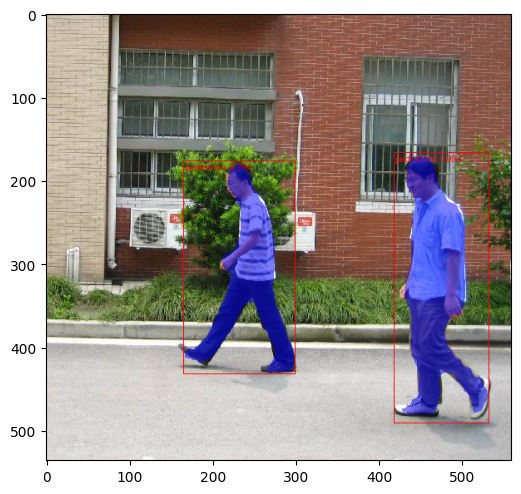

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("data/PennFudanPed/PNGImages/FudanPed00001.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(6, 6))
plt.imshow(output_image.permute(1, 2, 0))